In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<h1>1.1.	Описание набора данных</h1>

<h2>1.1.1.	Источник и методология сбора данных</h2>

In [50]:
!pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [51]:
!kaggle datasets download -d ihelon/coffee-sales # dataset from - https://www.kaggle.com/datasets/ihelon/coffee-sales/data

Dataset URL: https://www.kaggle.com/datasets/ihelon/coffee-sales
License(s): CC0-1.0
coffee-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
!unzip coffee-sales.zip -d /content


Archive:  coffee-sales.zip
checkdir:  cannot create extraction directory: /content
           Read-only file system


In [4]:
df = pd.read_csv('index.csv')

<h2>1.1.2.	Структура и содержание данных</h2>

In [5]:
df.head(4)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2175 non-null   object 
 1   datetime     2175 non-null   object 
 2   cash_type    2175 non-null   object 
 3   card         2086 non-null   object 
 4   money        2175 non-null   float64
 5   coffee_name  2175 non-null   object 
dtypes: float64(1), object(5)
memory usage: 102.1+ KB


In [55]:
df.shape

(2175, 6)

<h1>1.2.	Предобработка данных</h1>

<h2>1.2.1.	Очистка данных (обработка пропусков, аномалий)</h2>

In [56]:
# проверка есть ли пропуски

df.isnull().any()

date           False
datetime       False
cash_type      False
card            True
money          False
coffee_name    False
dtype: bool

In [57]:
# кол-во пропуков в стобце card по id

df['card'].isna().sum()

89

In [58]:
# количество заказов где cash_type = оплата наличными 

df['cash_type'][df['cash_type'] != 'card'].count()

89

In [59]:
df.dtypes

date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object

<h2>1.2.2.	Преобразование данных (нормализация, кодирование категориальных переменных)</h2>

День недели, месяц, час использовать как категориальные переменные.

In [7]:
df_norm = df.copy()

In [8]:
df_norm['datetime'] = pd.to_datetime(df_norm['datetime'])
df_norm['hour'] = df_norm['datetime'].dt.hour
df_norm['day_of_week'] = df_norm['datetime'].dt.dayofweek

In [9]:
# One-Hot Encoding для coffee_name
one_hot = pd.get_dummies(df_norm['coffee_name'], prefix='coffee')
df_norm = pd.concat([df_norm, one_hot], axis=1)
df_norm.drop('coffee_name', axis=1, inplace=True)

In [10]:
df_norm.head(5)

,date,datetime,cash_type,card,money,hour,day_of_week,coffee_Americano,coffee_Americano with Milk,coffee_Cappuccino,coffee_Cocoa,coffee_Cortado,coffee_Espresso,coffee_Hot Chocolate,coffee_Latte
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,10,4,False,False,False,False,False,False,False,True
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,12,4,False,False,False,False,False,False,True,False
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,12,4,False,False,False,False,False,False,True,False
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,13,4,True,False,False,False,False,False,False,False
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,13,4,False,False,False,False,False,False,False,True


Нормализация money

In [11]:
scaler = MinMaxScaler()
df_norm['money'] = scaler.fit_transform(df_norm[['money']])
df_norm['money']

0       0.940585
1       0.940585
2       0.940585
3       0.492687
4       0.940585
          ...   
2170    0.806216
2171    0.806216
2172    0.582267
2173    0.806216
2174    0.582267
Name: money, Length: 2175, dtype: float64

In [12]:
df_norm = pd.get_dummies(df_norm, columns=['cash_type'], drop_first=False)
df_norm = df_norm.drop(['cash_type_cash'] , axis=1)
df_norm.head(5)

,date,datetime,card,money,hour,day_of_week,coffee_Americano,coffee_Americano with Milk,coffee_Cappuccino,coffee_Cocoa,coffee_Cortado,coffee_Espresso,coffee_Hot Chocolate,coffee_Latte,cash_type_card
0,2024-03-01,2024-03-01 10:15:50.520,ANON-0000-0000-0001,0.940585,10,4,False,False,False,False,False,False,False,True,True
1,2024-03-01,2024-03-01 12:19:22.539,ANON-0000-0000-0002,0.940585,12,4,False,False,False,False,False,False,True,False,True
2,2024-03-01,2024-03-01 12:20:18.089,ANON-0000-0000-0002,0.940585,12,4,False,False,False,False,False,False,True,False,True
3,2024-03-01,2024-03-01 13:46:33.006,ANON-0000-0000-0003,0.492687,13,4,True,False,False,False,False,False,False,False,True
4,2024-03-01,2024-03-01 13:48:14.626,ANON-0000-0000-0004,0.940585,13,4,False,False,False,False,False,False,False,True,True


In [13]:
df_norm = df_norm.drop(['date'] , axis=1)

<h1>1.3.	Анализ данных с использованием Python</h1>

<h2>1.3.1.	Описательная статистика (использование библиотек Pandas и NumPy</h2>

In [67]:
df.describe()

,money
count,2175.000000
mean,31.725297
std,5.161150
min,18.120000
25%,27.920000
50%,32.820000
75%,35.760000
max,40.000000


In [68]:
print("Медиана 'money':", np.median(df_norm['money']))
print("Дисперсия 'money':", np.var(df_norm['money']))

Медиана 'money': 0.6718464351005484
Дисперсия 'money': 0.05561584406644454


In [69]:
# Частота напитков
print("Распределение напитков:")
print(df['coffee_name'].value_counts())

Распределение напитков:
coffee_name
Americano with Milk    526
Latte                  515
Cappuccino             315
Americano              282
Cortado                214
Hot Chocolate          149
Cocoa                   87
Espresso                87
Name: count, dtype: int64


In [70]:
# Межквартильный размах для переменной money
q1 = np.percentile(df['money'], 25)
q3 = np.percentile(df['money'], 75)
iqr = q3 - q1
print("Межквартильный размах денежных средств:", iqr)


Межквартильный размах денежных средств: 7.839999999999996


<h2>1.3.2.	Визуализация данных (графики и диаграммы с Matplotlib и Seaborn)</h2>

Количество транзакций (покупок) - распределение по месяцам

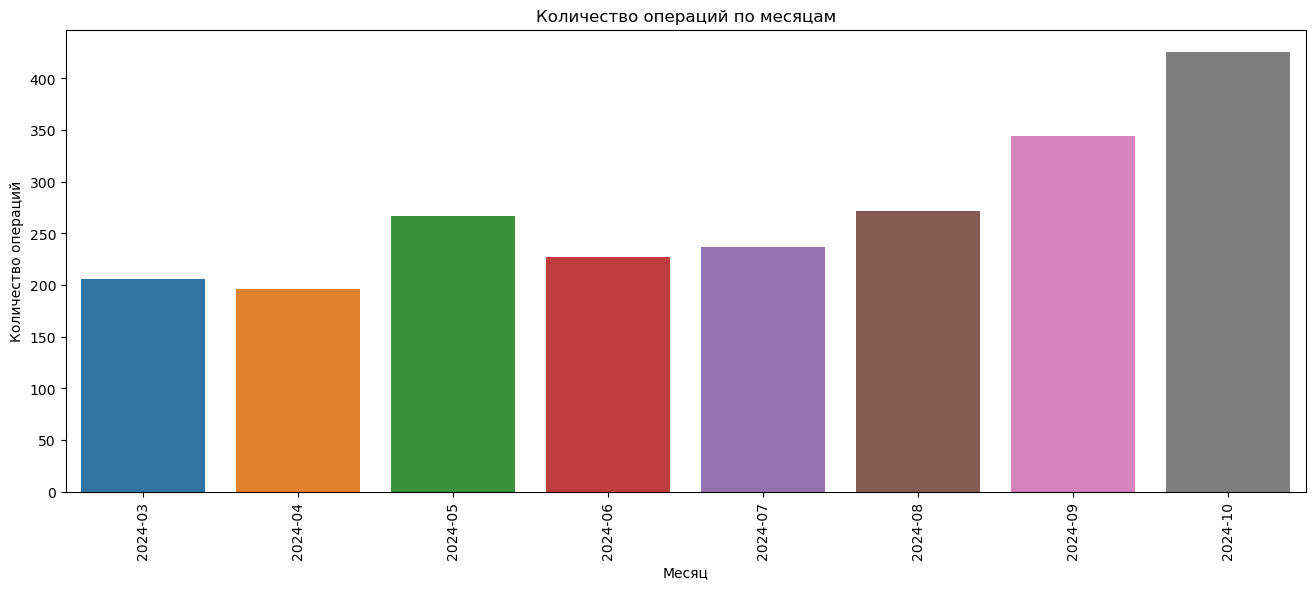

In [79]:
#df['date'] = pd.to_datetime(df['date'])

# Извлекаем год и месяц из столбца 'date' и создаем новый столбец 'year_month'
df['year_month'] = df['date'].dt.to_period('M')

# Группируем по 'year_month' и считаем количество операций
operation_counts = df.groupby('year_month').size().reset_index(name='count')

# Построение графика
plt.figure(figsize=(16, 6))
sns.barplot(data=operation_counts, x='year_month', y='count')
plt.xticks(rotation=90)
plt.xlabel('Месяц')
plt.ylabel('Количество операций')
plt.title('Количество операций по месяцам')
plt.show()

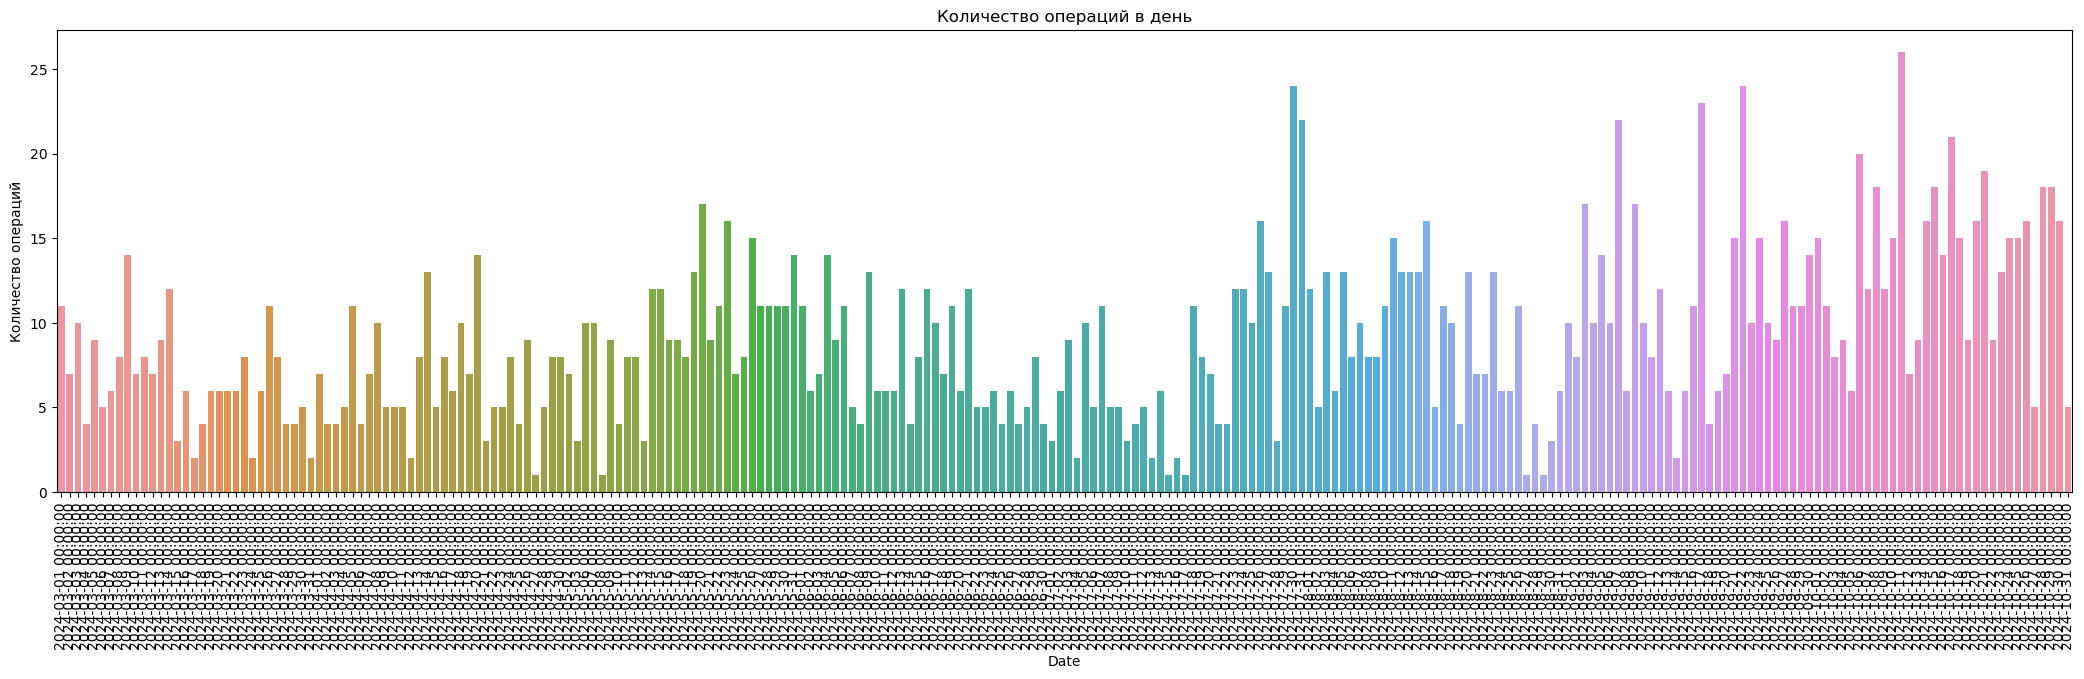

In [77]:
df['date'] = pd.to_datetime(df['date'])

operation_counts = df.groupby('date').size().reset_index(name='count')

plt.figure(figsize=(26, 6))
sns.barplot(data=operation_counts, x='date', y='count')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Количество операций')
plt.title('Количество операций в день')
plt.show()

 Количество транзакций - распределение по видам платежей

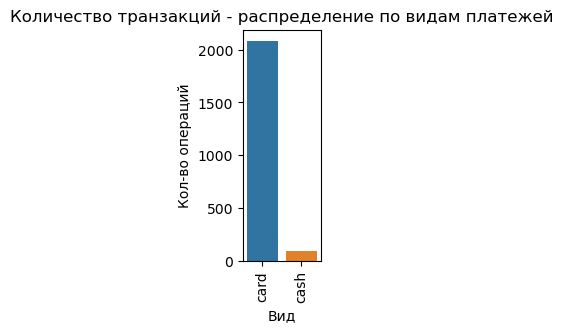

In [72]:
operation_type = df.groupby('cash_type').size().reset_index(name='count')
operation_type

plt.figure(figsize=(1, 3))
sns.barplot(data=operation_type, x='cash_type', y='count')
plt.xticks(rotation=90)
plt.xlabel('Вид')
plt.ylabel('Кол-во операций')
plt.title('Количество транзакций - распределение по видам платежей')
plt.show()

Распределение сортов кофе

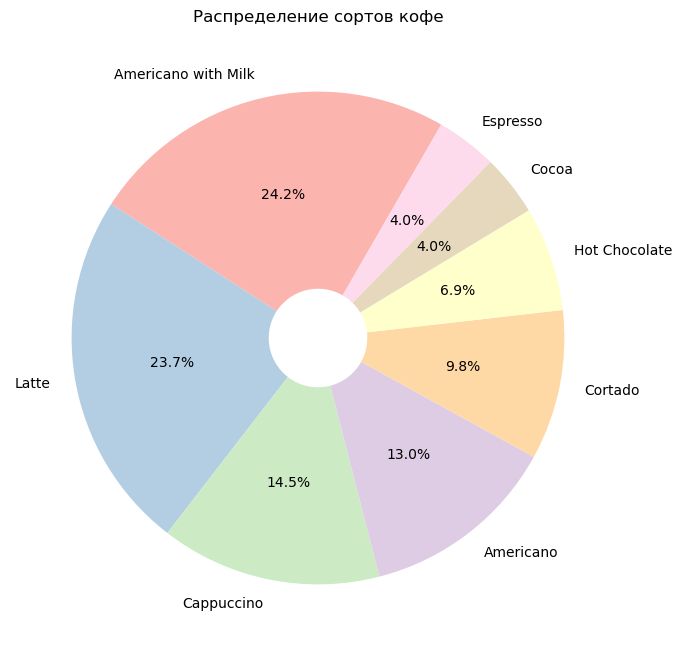

In [73]:
coffee_counts = df['coffee_name'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(coffee_counts,
        labels=coffee_counts.index,
        autopct='%1.1f%%',
        startangle=60,
        colors=sns.color_palette("Pastel1"),
        wedgeprops={'width': 0.8})
plt.title('Распределение сортов кофе')
plt.show()

Количество покупок в разбивке по часам

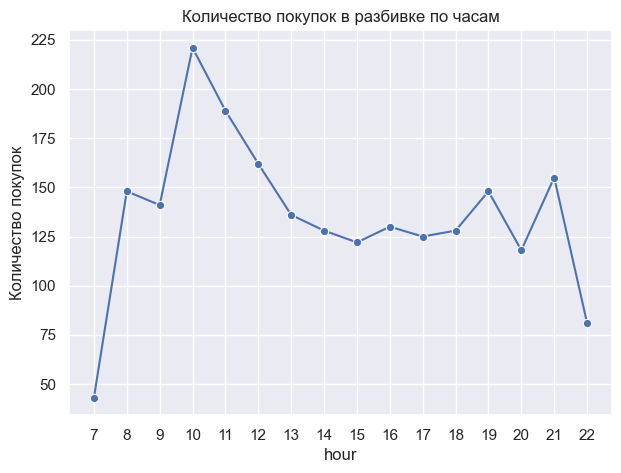

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])


df['hour'] = df['datetime'].dt.hour

hourly_purchases = df.groupby('hour').size().reset_index(name='purchases')

plt.figure(figsize=(7, 5))
sns.lineplot(x='hour', y='purchases', data=hourly_purchases, marker='o')
plt.xticks(hourly_purchases['hour'])
plt.ylabel('Количество покупок')
plt.title('Количество покупок в разбивке по часам')
plt.show()

Визуализация покупок кофе по  часам / дням недели / месяцам

In [78]:
# add new feature

def weekday_transform(x):
  days_of_week = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'}
  return days_of_week[x]


df['weekday'] = pd.to_datetime(df['date']).dt.weekday
df['weekday'] = df['weekday'].apply(weekday_transform)
df['weekday'].value_counts()

weekday
Вторник        363
Понедельник    317
Четверг        313
Пятница        301
Среда          297
Воскресенье    295
Суббота        289
Name: count, dtype: int64

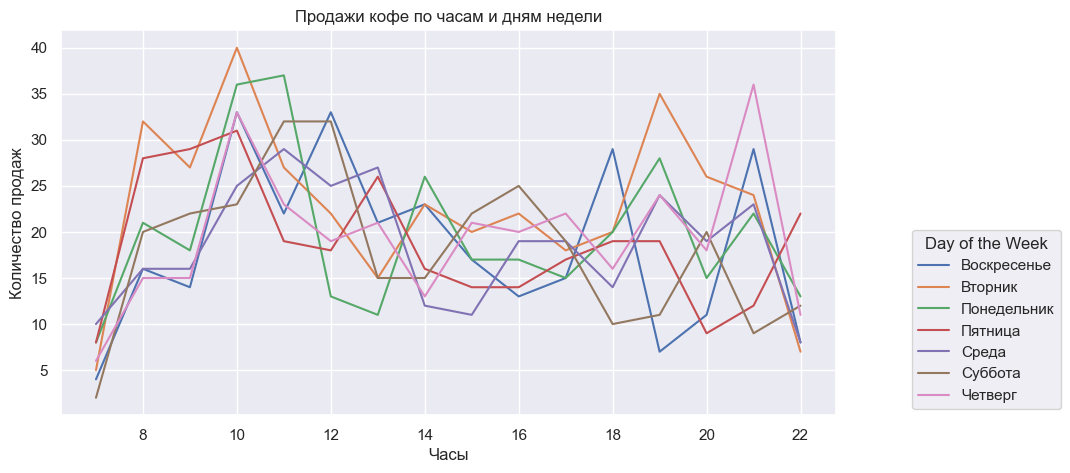

In [ ]:
daily_hourly_summary = df.groupby(['weekday', 'hour']) \
    .agg({'money': ['count']}).reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_hourly_summary, x='hour', y=('money', 'count'),
             hue='weekday')
plt.xlabel('Часы')
plt.ylabel('Количество продаж')
plt.title('Продажи кофе по часам и дням недели')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.3, 0.5));

Гистограмма цены на кофе

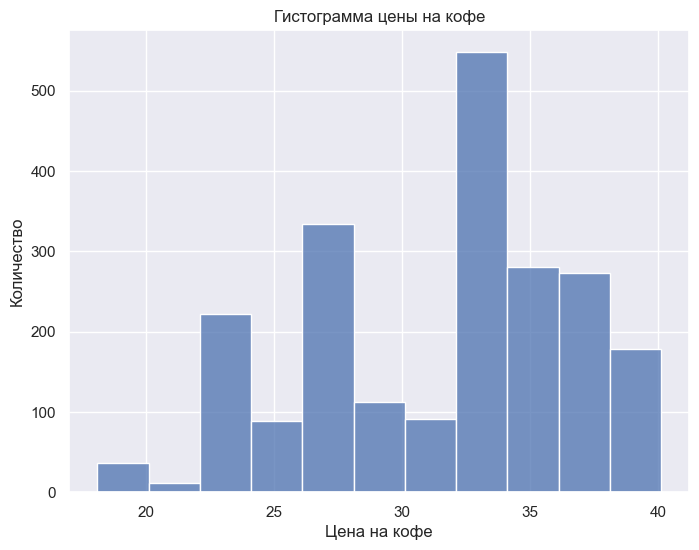

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['money'], bins=10, binwidth=2)

plt.xlabel('Цена на кофе')
plt.ylabel('Количество')
plt.title('Гистограмма цены на кофе')
plt.show()

<h1>1.4.	 Обучение моделей и прогнозирование продаж </h1>

In [14]:
# Обработка данных
X = df_norm[['hour', 'day_of_week', 'coffee_Americano', 'coffee_Americano with Milk', 'coffee_Cappuccino', 'coffee_Cocoa', 
        'coffee_Cortado', 'coffee_Espresso', 'coffee_Hot Chocolate', 'coffee_Latte']]
X = X.apply(pd.to_numeric)  # Преобразование категориальных данных

y = df_norm['money']

In [16]:
X.head()

,hour,day_of_week,coffee_Americano,coffee_Americano with Milk,coffee_Cappuccino,coffee_Cocoa,coffee_Cortado,coffee_Espresso,coffee_Hot Chocolate,coffee_Latte
0,10,4,False,False,False,False,False,False,False,True
1,12,4,False,False,False,False,False,False,True,False
2,12,4,False,False,False,False,False,False,True,False
3,13,4,True,False,False,False,False,False,False,False
4,13,4,False,False,False,False,False,False,False,True


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((1740, 10), (435, 10), (1740,), (435,))

<h3>1.4.2.Настройка и обучение моделей</h3>
    
<h3>1.4.3.	Метрики оценки (например MAE, RMSE, R²)</h3>

In [20]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Обучение модели
    y_pred = model.predict(X_test)  # Прогнозы на тестовой выборке

    # Вычисление метрик:
    mae = mean_absolute_error(y_test, y_pred)  # Средняя абсолютная ошибка
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Среднеквадратичная ошибка
    r2 = r2_score(y_test, y_pred)  # Коэффициент детерминации (R²)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Оценка результатов
results_df = pd.DataFrame(results).T
print("\nРезультаты оценки модели:\n", results_df)


Результаты оценки модели:
                                MAE      RMSE        R²
Linear Regression         0.093147  0.106720  0.792147
Decision Tree             0.088655  0.115512  0.756487
Random Forest             0.087838  0.108200  0.786342
Gradient Boosting         0.089799  0.102695  0.807530
Support Vector Regressor  0.097690  0.110709  0.776317


<h2>1.4.4. Визуализация результатов</h2>

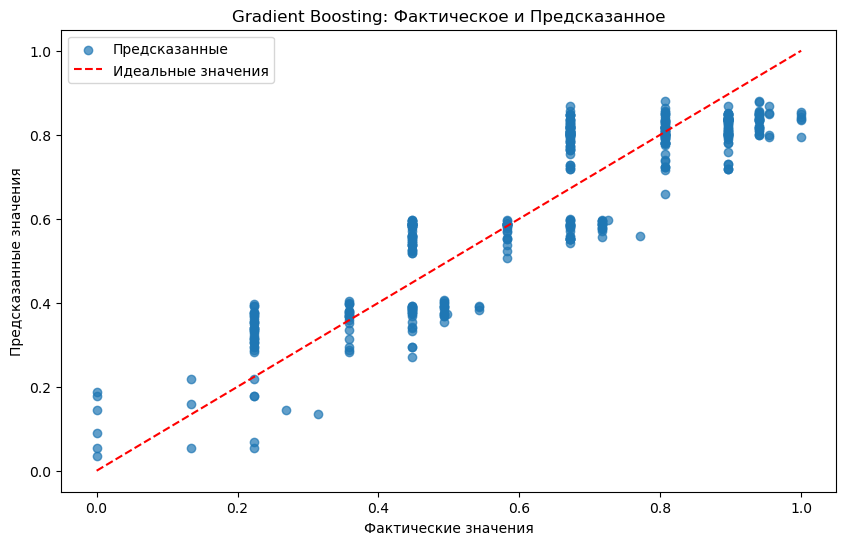

In [21]:
best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7, label='Предсказанные')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label='Идеальные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title(f'{best_model_name}: Фактическое и Предсказанное')
plt.legend()
plt.show()

<h2>1.4.5. Прогнозирование продаж</h2>

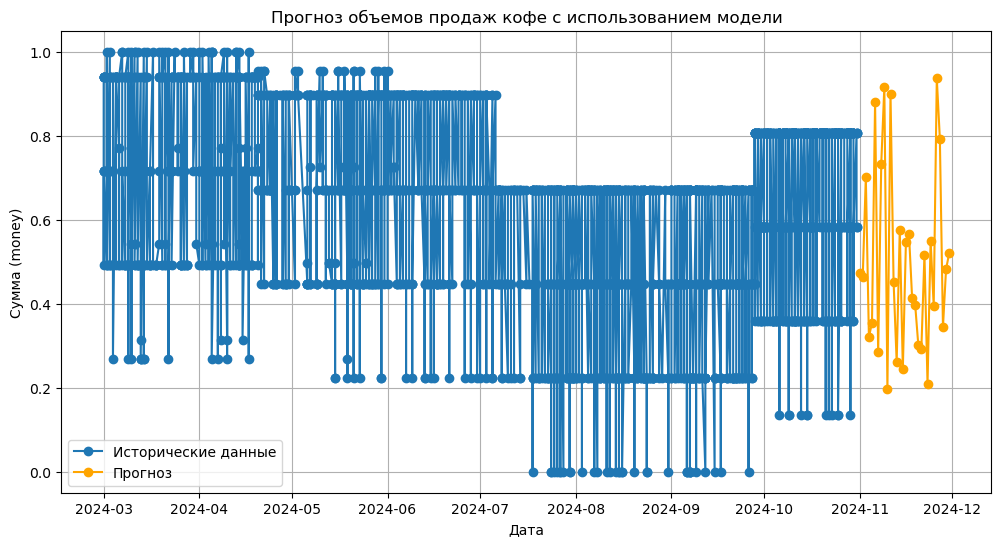

In [46]:
# Дальнейший период прогнозирования
future_periods = 30  # количество периодов, на которые хотим сделать прогноз

# Создаем новые данные для прогноза
future_data = pd.DataFrame({
    'hour': np.random.randint(0, 24, future_periods),
    'day_of_week': np.random.randint(0, 7, future_periods),
    'coffee_Americano': np.random.choice([True, False], future_periods),
    'coffee_Americano with Milk': np.random.choice([True, False], future_periods),
    'coffee_Cappuccino': np.random.choice([True, False], future_periods),
    'coffee_Cocoa': np.random.choice([True, False], future_periods),
    'coffee_Cortado': np.random.choice([True, False], future_periods),
    'coffee_Espresso': np.random.choice([True, False], future_periods),
    'coffee_Hot Chocolate': np.random.choice([True, False], future_periods),
    'coffee_Latte': np.random.choice([True, False], future_periods)
})

# Преобразование категориальных данных
future_data = future_data.apply(pd.to_numeric)

# Прогнозирование
future_predictions = best_model.predict(future_data)

# df_fk['datetime'] = pd.to_datetime(df_norm['datetime'])
# df_fk['hour'] = df_fk['datetime'].dt.hour
# df_fk['day_of_week'] = df_fk['datetime'].dt.dayofweek

last_date = pd.to_datetime(df_fk['date']).max() 
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_periods)
forecast_df = pd.DataFrame({'date': future_dates, 'predicted money': future_predictions})

# Визуализация исторических данных и прогноза
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df_fk['date']), df_norm['money'], label='Исторические данные', marker='o')
plt.plot(forecast_df['date'], forecast_df['predicted money'], label='Прогноз', color='orange', marker='o')
plt.title('Прогноз объемов продаж кофе с использованием модели')
plt.xlabel('Дата')
plt.ylabel('Сумма (money)')
plt.legend()
plt.grid(True)
plt.show()

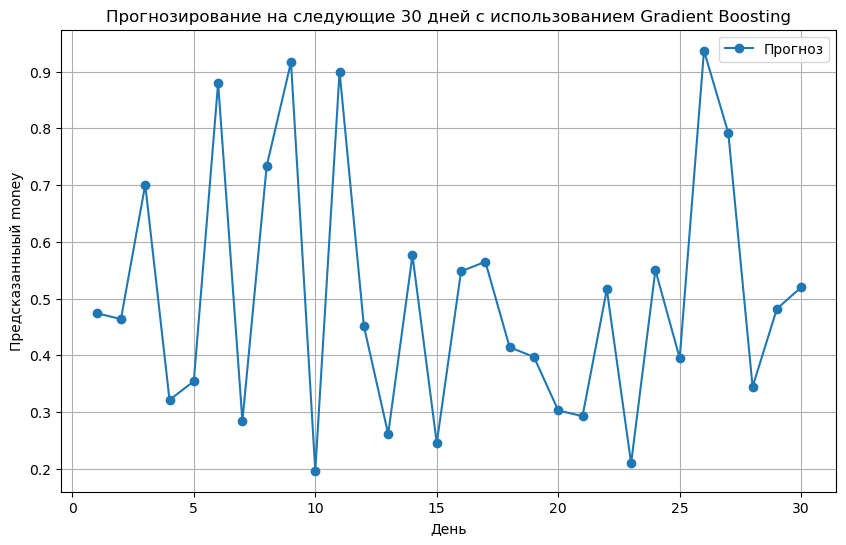

In [51]:
# Визуализация только прогноза 
plt.figure(figsize=(10, 6))
plt.plot(range(1, future_periods + 1), future_predictions, marker='o', label='Прогноз') 
plt.xlabel('День')
plt.ylabel('Предсказанныый money')
plt.title(f'Прогнозирование на следующие {future_periods} дней с использованием {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

<h2>1.5. Рекомендации по повышению продаж кофе</h2>


Рекомендации:
1. Продвигать популярные позиции (Latte, Hot Chocolate) с акциями или скидками.
2. Улучшить видимость менее популярных позиций (Cappuccino, Cocoa).
3. Разработать предложения в зависимости от времени дня.